In [5]:
import pandas as pd
from src.paths import LOCAL_RAW_DATA_PATH, LOCAL_PROCESSED_DATA_PATH
from tqdm._tqdm_notebook import tqdm_notebook
import missingno as msno
from sklearn.preprocessing import LabelEncoder
import pickle
from src.paths import LOCAL_MODELS_PATH

tqdm_notebook.pandas()
tweets_path = LOCAL_PROCESSED_DATA_PATH / 'tweets_with_embeddings.pkl'
tweets = pd.read_pickle(tweets_path)

In [13]:
prices_path  = LOCAL_PROCESSED_DATA_PATH / 'btc-usd_featurized.pkl'
prices = pd.read_pickle(prices_path)

In [24]:
tweets.id_str = tweets.id_str.astype(str)

In [25]:
df = tweets.merge(prices, how='outer', left_on='created_at_trunc_h', right_on='date')
df.head(2).T

,0,1
created_at,2021-05-02 23:35:51,2021-05-02 23:29:46
id,1.389e+18,1.389e+18
id_str,1389000716832944128,1388999185291091968
full_text,"""taproot"": {\n ""type"": ""bip9"",\n ""bi...",@_CryptoTrojan Wait a day or two
truncated,False,False
display_text_range,"[0, 267]","[15, 32]"
entities,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'hashtags': [], 'symbols': [], 'user_mentions..."
source,"<a href=""https://about.twitter.com/products/tw...","<a href=""http://twitter.com/download/android"" ..."
in_reply_to_status_id,1.38893e+18,1.38893e+18
in_reply_to_status_id_str,1.38893e+18,1.38893e+18


<AxesSubplot:>

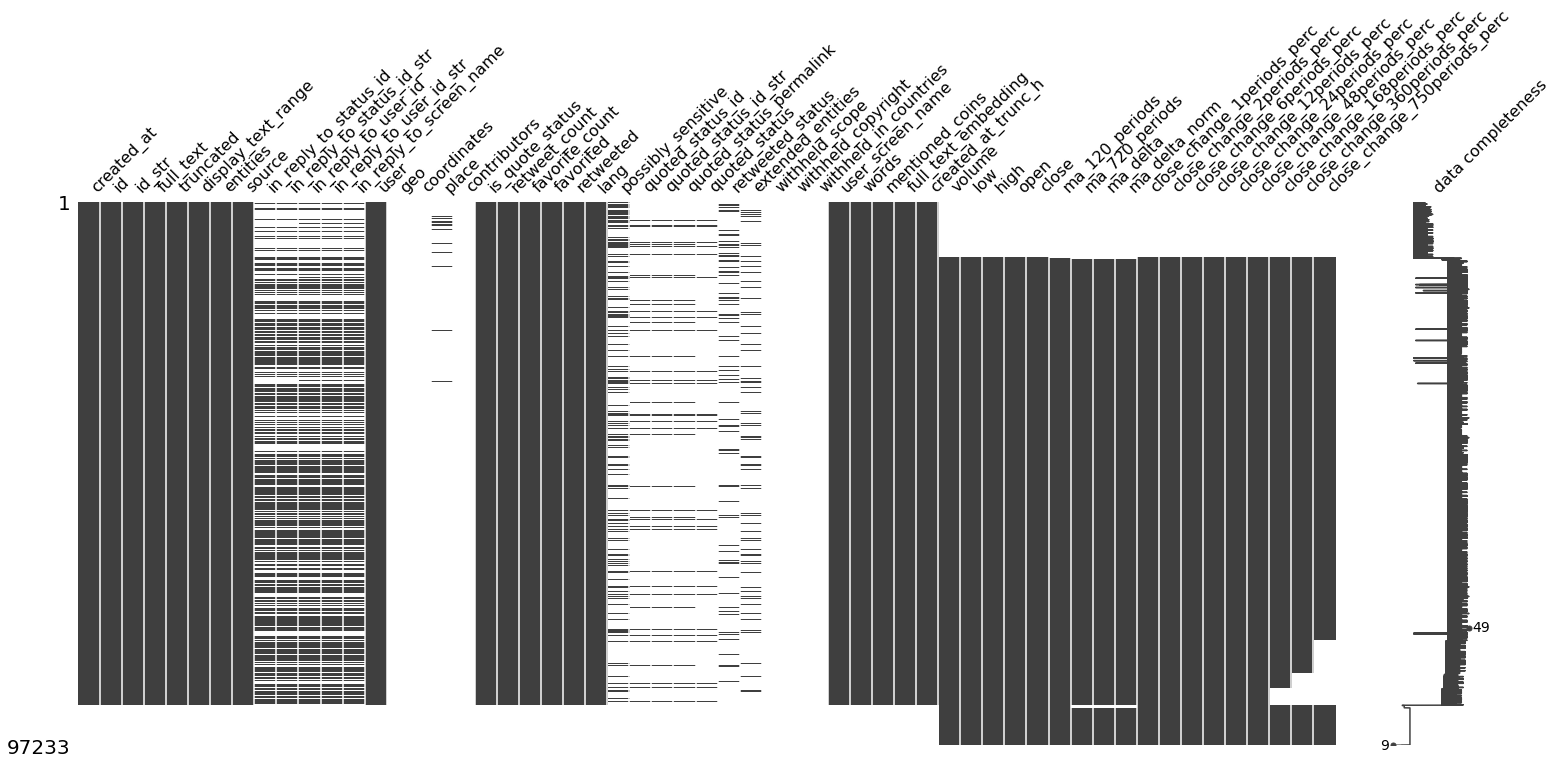

In [46]:
%matplotlib inline

msno.matrix(df.sort_values('created_at'), labels=True)

In [49]:
df.columns

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang',
       'possibly_sensitive', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status_permalink', 'quoted_status', 'retweeted_status',
       'extended_entities', 'withheld_scope', 'withheld_copyright',
       'withheld_in_countries', 'user_screen_name', 'words', 'mentioned_coins',
       'full_text_embedding', 'created_at_trunc_h', 'volume', 'low', 'high',
       'open', 'close', 'ma_120_periods', 'ma_720_periods', 'ma_delta',
       'ma_delta_norm', 'close_change_1periods_perc',
       'close_change_2periods_perc', 'close_change_6periods_perc',
       'close_change_1

<AxesSubplot:>

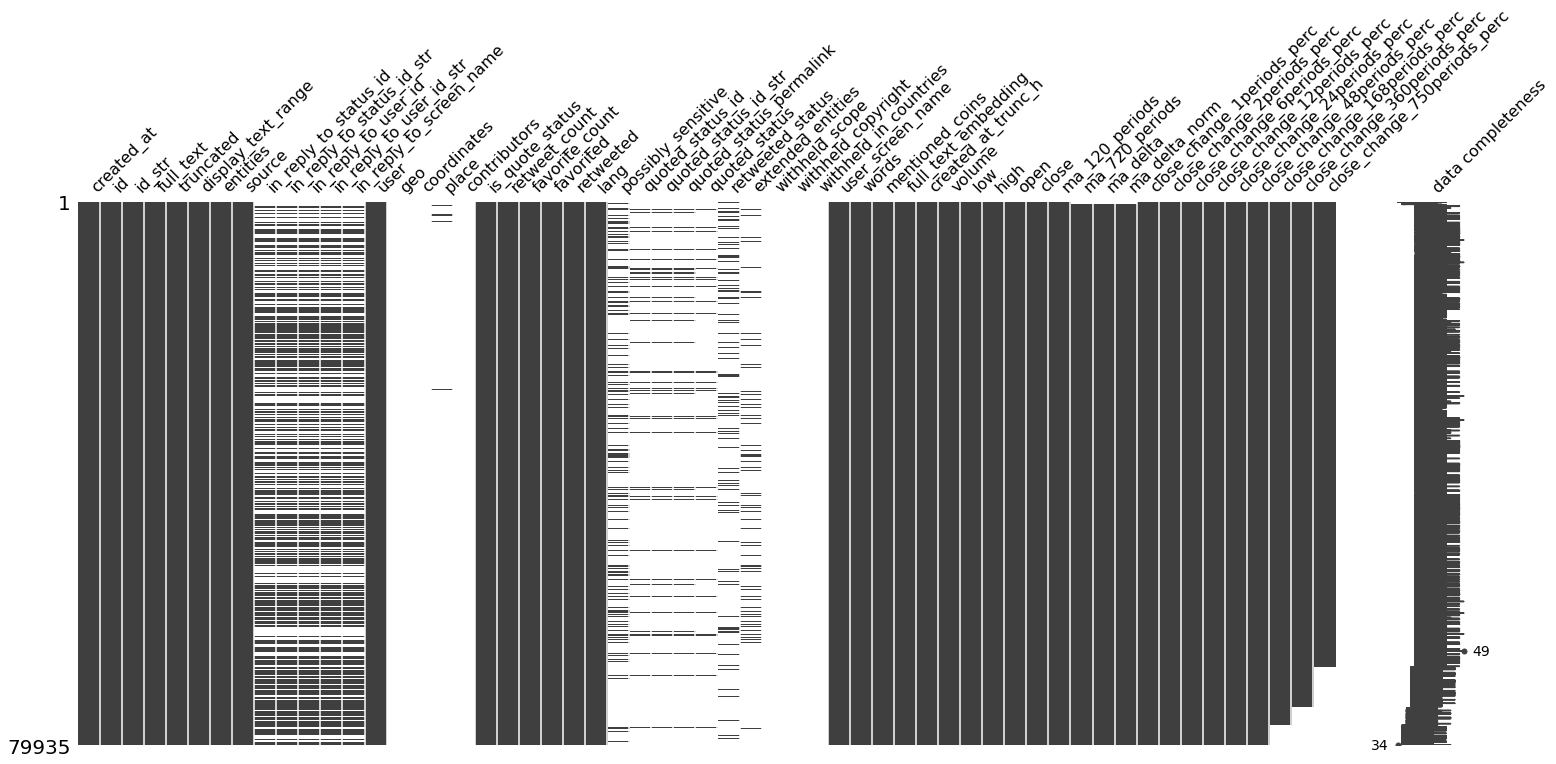

In [65]:
mask = df.close_change_1periods_perc.notna() & df.id_str.notna()
df = df[mask].sort_values('created_at')
msno.matrix(df, labels=True)

In [147]:
user_le = LabelEncoder() 
df['user_feat'] = user_le.fit_transform(df.user_screen_name)
with open(LOCAL_MODELS_PATH / 'user_label_encoder.pkl', 'wb') as fp:
    pickle.dump(user_le, fp)

In [99]:
rel_coins = ['BTC', 'ETH', 'LTC', 'DOGE',  'USDT',]
df['mentioned_coins'] = df.mentioned_coins.apply(lambda x: [c for c in x if c in rel_coins])
coins = df['mentioned_coins'].explode()
df = df.join((pd.crosstab(coins.index, coins)>0).astype(int))
df[rel_coins] = df[rel_coins].fillna(0).astype(int)

In [133]:
cols = ['created_at', 'created_at_trunc_h', 'id_str', 'full_text',
        'retweet_count', 'favorite_count', 'user_screen_name', 'user_feat',
         'BTC', 'DOGE', 'ETH', 'LTC', 'USDT',
        'volume', 'close', 'ma_120_periods', 'ma_720_periods',
        'close_change_1periods_perc', 'close_change_2periods_perc', 'close_change_6periods_perc',
        'close_change_12periods_perc', 'close_change_24periods_perc', 'close_change_48periods_perc',
        'close_change_168periods_perc', 'close_change_360periods_perc', 'close_change_750periods_perc',
]

In [111]:
embeddings = df.full_text_embedding.progress_apply(pd.Series)

  0%|          | 0/79935 [00:00<?, ?it/s]

<AxesSubplot:>

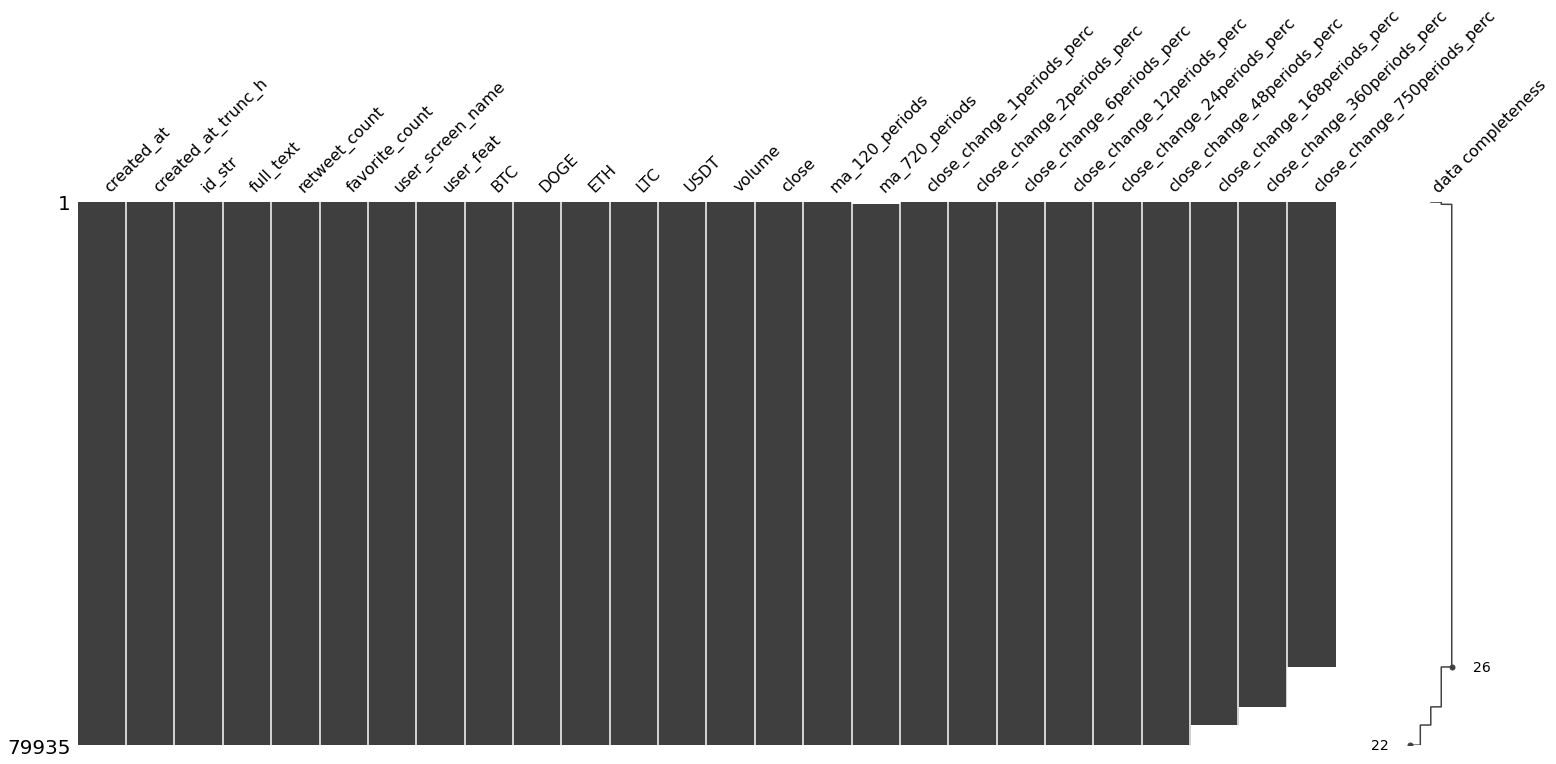

In [143]:
msno.matrix(df[cols], labels=True)

In [146]:
df[cols].join(embeddings).to_pickle(LOCAL_PROCESSED_DATA_PATH / 'pretrain_dataset.pkl')